# Part 2 : Tuning model's hyperparameters

### Loading libraries

In [36]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn
import time
%matplotlib inline

In [37]:
from sklearn.model_selection import cross_val_score,train_test_split,GridSearchCV
from sklearn.preprocessing import StandardScaler,OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.compose import ColumnTransformer
from sklearn.metrics import mean_squared_error
from sklearn import feature_selection

In [38]:
from sklearn.linear_model import LinearRegression,Ridge,Lasso,SGDRegressor,LogisticRegression,LassoCV
from sklearn.ensemble import RandomForestRegressor,GradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor

In [39]:
#func for writing prediction into csv file
def write_sumb(name,prediction):
    pd.DataFrame({'Id':range(1461,1461+1459),'SalePrice':prediction}).to_csv(name,index=False)

### Loading dataset with filled nan's

In [40]:
train = pd.read_csv('train_clean.csv')
test = pd.read_csv('test_clean.csv')
y = train.SalePrice
X = train.drop('SalePrice',axis=1)

In [41]:
numeric = np.where((X.dtypes=='int')|(X.dtypes=='float'))[0]
feat_to_drop = ['3SsnPorch',
 'MoSold',
 'GarageArea',
 'LowQualFinSF',
 'YrSold',
 'MiscVal',
 'OpenPorchSF',
 'BsmtHalfBath',
 'BsmtFinSF2',
 'MSSubClass',
 'BsmtUnfSF']
feats = set(X.columns[numeric]).intersection(set(feat_to_drop))
X.drop(feats, axis=1, inplace=True)
test.drop(feats, axis=1, inplace=True)

In [42]:
# preprocessing of columns(normalization for numeric and onehotencoding for categoric)
categorical_features = np.where(X.dtypes=='object')[0]
categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

numeric_features = np.where((X.dtypes=='int')|(X.dtypes=='float'))[0]
numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])

In [43]:
X = preprocessor.fit_transform(X)
test = preprocessor.transform(test)
X = X.toarray()
test = test.toarray()

In [44]:
# Checking cross-validation score on different algorithms

In [86]:
results = pd.DataFrame(columns = ['name','cross_val_score','time'])

In [87]:
def evaluate_score(model,X=X,y=y):
    ''' 
    Function counts cross-validation score, holdout (on test set) score, time (overall train + prediction) of model
    Crossval score is rmse, cv = 3
    
    '''
    time_before = time.time() 
    model_instance = model
    cvs = np.int(np.abs(cross_val_score(model,X,y,cv=5,scoring='neg_root_mean_squared_error').mean()))
    if cvs>1e11:
        cvs = np.inf

    time_after = time.time()
    result = pd.DataFrame({'name':model.__class__.__name__,'cross_val_score':cvs,
                           'time':time_after - time_before},index=[0])
    return result

In [88]:
#tree models : DecisionTreeRegressor, RandomForestRegressor, GradientBoostingRegressor
#distance models : KNeighborsRegressor
#linear models : LinearRegression, Ridge, Lasso, SGDRegressor
regressors = [Ridge(random_state = 5),
              Lasso(random_state=5),DecisionTreeRegressor(random_state=5),
              SGDRegressor(random_state=5),GradientBoostingRegressor(random_state=5),
              RandomForestRegressor(random_state=5),KNeighborsRegressor()]

In [89]:
for regressor in regressors:
    results = results.append(evaluate_score(regressor))

/Users/borisevich.vd/venv/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 10711557766.213501, tolerance: 699031751.5199751
  model = cd_fast.enet_coordinate_descent(


In [94]:
results.cross_val_score = results.cross_val_score.apply(np.int)
results.sort_values(by='cross_val_score')

,name,cross_val_score,time
0,GradientBoostingRegressor,25944,2.975489
0,RandomForestRegressor,29487,8.324287
0,Ridge,31438,0.045692
0,SGDRegressor,31603,0.106361
0,Lasso,33008,0.728157
0,KNeighborsRegressor,36794,0.632640
0,DecisionTreeRegressor,39192,0.186683


In [72]:
# Grid search for regressors
# Searching for optimal hyperparameters

In [95]:
results_grid = pd.DataFrame(columns = ['name','cross_val_score','time'])

In [97]:
def evaluate_score_grid(model,params,X=X,y=y):
    ''' Gridsearch for different models'''
    name = model.__class__.__name__
    time_before = time.time() 
    model_instance = GridSearchCV(model,params,cv=5,scoring='neg_root_mean_squared_error').fit(X,y)
    cvs = np.int(np.abs(model_instance.best_score_))
    print(model,model_instance.best_params_)
    if cvs>1e10:
        cvs=np.inf
    time_after = time.time()
    result = pd.DataFrame({'name':name,'cross_val_score':cvs,
                           'time':time_after - time_before},index=[0])
    return result

In [102]:
regressors = [Ridge(),Lasso(),DecisionTreeRegressor(),
              SGDRegressor(),GradientBoostingRegressor(),
              RandomForestRegressor(),KNeighborsRegressor()]

In [103]:
ridge_params = {
    'alpha':[1,1.5,2,5,10,100,200,500,1000],
    'max_iter':[1000,2000],
    'random_state':[5]
}
lasso_params = {
    'alpha':[1,1.5,2,5,10,100,200,500,1000],
    'max_iter':[1000,2000],
    'random_state':[5]
}
tree_params = {
    'max_depth':[3,5,8,10,15],
    'min_samples_leaf':[1,2,5,10],
    'random_state':[5]   
}
SGDRegressor_params = {
    'penalty':['l2','l1','elasticnet'],
    'max_iter':[1000,2000,5000],
    'learning_rate':['invscaling','optimal'],
    'random_state':[5]
}
GradientBoostingRegressor_params = {
    'learning_rate':[0.01,0.05,0.1],
    'n_estimators':[500,1000,2000],
    'random_state':[5]
}
RandomForestRegressor_params = {
    'n_estimators':[500,1000,2000],
    'max_depth':[5,10,None],
    'random_state':[5]
}
KNeighborsRegressor_params = {
    'n_neighbors':[3,5,7,9],
    'weights':['uniform','distance'],
    'algorithm':['ball_tree','kd_tree','brute']
}
params = [ridge_params,lasso_params,tree_params,
          SGDRegressor_params,GradientBoostingRegressor_params,
          RandomForestRegressor_params,KNeighborsRegressor_params]

In [104]:
%%time
for i,regressor in enumerate(regressors):
    results_grid = results_grid.append(evaluate_score_grid(regressor,params=params[i]))

Ridge() {'alpha': 10, 'max_iter': 1000, 'random_state': 5}


/Users/borisevich.vd/venv/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 10711557766.213501, tolerance: 699031751.5199751
  model = cd_fast.enet_coordinate_descent(


Lasso() {'alpha': 200, 'max_iter': 1000, 'random_state': 5}
DecisionTreeRegressor() {'max_depth': 10, 'min_samples_leaf': 10, 'random_state': 5}
SGDRegressor() {'learning_rate': 'invscaling', 'max_iter': 1000, 'penalty': 'l2', 'random_state': 5}
GradientBoostingRegressor() {'learning_rate': 0.1, 'n_estimators': 500, 'random_state': 5}
RandomForestRegressor() {'max_depth': None, 'n_estimators': 2000, 'random_state': 5}
KNeighborsRegressor() {'algorithm': 'brute', 'n_neighbors': 9, 'weights': 'distance'}
CPU times: user 17min 33s, sys: 12.3 s, total: 17min 46s
Wall time: 17min 11s


In [105]:
#results_grid.cross_val_score = results_grid.cross_val_score.apply(np.int)
results_grid.sort_values(by='cross_val_score')

,name,cross_val_score,time
0,GradientBoostingRegressor,25064,335.857267
0,RandomForestRegressor,29022,664.894766
0,Lasso,29985,5.788689
0,Ridge,30726,0.557386
0,SGDRegressor,31603,13.044799
0,KNeighborsRegressor,34645,9.598487
0,DecisionTreeRegressor,37262,1.501167


In [107]:
# regressors with best parameters
regressors_opt = [LinearRegression(),Ridge(alpha=10,max_iter=1000,random_state=5),
                  Lasso(alpha=200,max_iter=1000,random_state=5),
                  DecisionTreeRegressor(max_depth=15,min_samples_leaf=10,random_state=5),
                  SGDRegressor(max_iter=1000,penalty='l2',learning_rate='invscaling',random_state=5),
                  GradientBoostingRegressor(learning_rate=0.01,n_estimators=2000,random_state=5),
                  RandomForestRegressor(max_depth=None,n_estimators=2000,random_state=5),
                  KNeighborsRegressor(algorithm='ball_tree',n_neighbors=9,weights='distance')]

## Reducing dimension with PCA(0.95 explained variance) 

In [108]:
pca = PCA(n_components = 0.95)
X_pca = pca.fit_transform(X)
test_pca = pca.transform(test)

In [109]:
results_pca = pd.DataFrame(columns = ['name','cross_val_score','time'])

In [110]:
for regressor in regressors_opt:
    results_pca = results_pca.append(evaluate_score(regressor,X_pca,y))

In [111]:
results_pca.sort_values(by='cross_val_score')

,name,cross_val_score,time
0,GradientBoostingRegressor,27613,171.106915
0,RandomForestRegressor,29318,321.897328
0,Lasso,32201,0.017895
0,Ridge,32229,0.016664
0,LinearRegression,32392,0.041692
0,SGDRegressor,32694,0.029505
0,KNeighborsRegressor,34606,0.135799
0,DecisionTreeRegressor,36461,0.218796


## Feature selection 
### Selection with LassoCV model

In [112]:
results_feat_select = pd.DataFrame(columns = ['name','cross_val_score','time'])

In [113]:
selector = feature_selection.SelectFromModel(LassoCV(cv=5,random_state=5)).fit(X,y)
X_selected = selector.transform(X)
test_selected = selector.transform(test)

In [114]:
X.shape[1] - X_selected.shape[1] # amount of columns were dropped (overall 270 columns)

176

In [115]:
for regressor in regressors_opt:
    results_feat_select = results_feat_select.append(evaluate_score(regressor,X_selected,y))

In [116]:
results_feat_select.sort_values(by='cross_val_score')

,name,cross_val_score,time
0,GradientBoostingRegressor,24705.0,33.705348
0,RandomForestRegressor,28794.0,99.421176
0,Ridge,29433.0,0.014298
0,Lasso,29850.0,0.079406
0,SGDRegressor,31587.0,0.051708
0,KNeighborsRegressor,34415.0,0.157633
0,DecisionTreeRegressor,37243.0,0.059794
0,LinearRegression,inf,0.045076


## Merging all results

In [117]:
res = pd.merge(results, results_grid, how='left', left_on='name', right_on='name', suffixes=('', '_grid'))
res = pd.merge(res, results_pca, how='left', left_on='name', right_on='name', suffixes=('', '_pca'))
res = res = pd.merge(res, results_feat_select, how='left', left_on='name', right_on='name', suffixes=('', '_sel'))

In [118]:
res

,name,cross_val_score,time,cross_val_score_grid,time_grid,cross_val_score_pca,time_pca,cross_val_score_sel,time_sel
0,Ridge,31438,0.045692,30726,0.557386,32229,0.016664,29433.0,0.014298
1,Lasso,33008,0.728157,29985,5.788689,32201,0.017895,29850.0,0.079406
2,DecisionTreeRegressor,39192,0.186683,37262,1.501167,36461,0.218796,37243.0,0.059794
3,SGDRegressor,31603,0.106361,31603,13.044799,32694,0.029505,31587.0,0.051708
4,GradientBoostingRegressor,25944,2.975489,25064,335.857267,27613,171.106915,24705.0,33.705348
5,RandomForestRegressor,29487,8.324287,29022,664.894766,29318,321.897328,28794.0,99.421176
6,KNeighborsRegressor,36794,0.632640,34645,9.598487,34606,0.135799,34415.0,0.157633


In [121]:
process = ['base','grid','pca','selection']
labels = res.loc[:,'name']
score_names = ['cross_val_score','cross_val_score_grid','cross_val_score_pca','cross_val_score_sel']

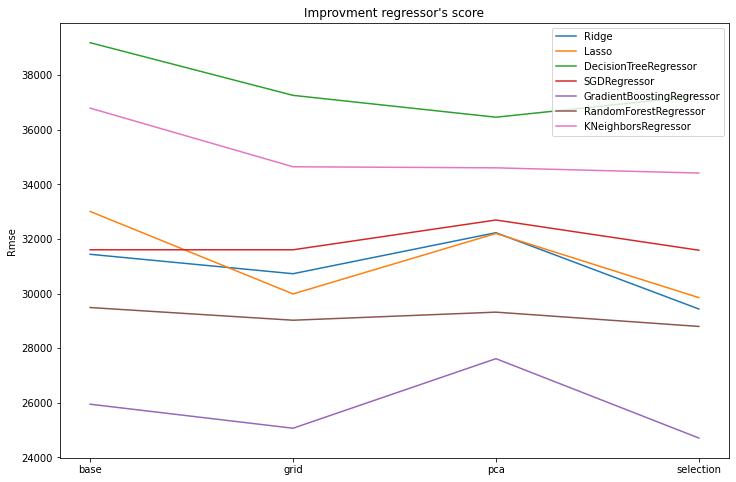

In [128]:
plt.figure(figsize=(12,8))
for i in range(res.shape[0]):
    res.loc[i,score_names].plot()
plt.legend(labels,loc=1)
plt.ylabel('Rmse')
plt.title("Improvment regressor's score")
plt.xticks(ticks = np.arange(4),labels=process);

PCA method of reducing dimensions worked bad. The main reason for this is that the data has a low correlation with SalePrice. Lasso selection sligthly improved quality of prediction. Because it removed not informative features(handle with multicollinearity).

In [131]:
X_train,X_test,y_train,y_test = train_test_split(X_selected,y)

In [134]:
gbr = GradientBoostingRegressor(learning_rate=0.01,n_estimators=2000,random_state=5)
gbr.fit(X_train,y_train)

GradientBoostingRegressor(learning_rate=0.01, n_estimators=2000, random_state=5)

In [136]:
prediction = gbr.predict(X_test)

In [170]:
np.sum(np.abs((prediction - y_test)/y_test)*100)/1095

2.9049727365506013

In [184]:
mape = np.abs((prediction - y_test)/y_test)*100

In [185]:
mape = mape.reset_index()

In [188]:
mape.drop('index',axis=1,inplace=True)

<AxesSubplot:>

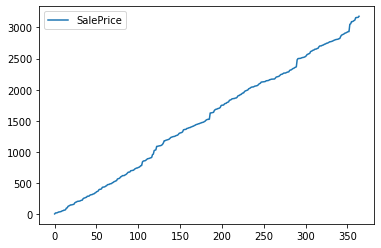

In [191]:
mape.cumsum().plot()